<a href="https://colab.research.google.com/github/marcelogarret/projeto_mestrado/blob/main/EBM_FIT_UNISIM_D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.optimize import minimize
from sklearn.metrics import r2_score

df=pd.read_excel('unisim_hist.xlsx')
# df=pd.read_excel('unisim_hist.xlsx').iloc[:, :-5]
print(df.head())

        Date  Press      Np        Gp  Wp  Winj     Press_b    Np_b  \
0 2013-05-31    332       0         0   0     0  335.219147       0   
1 2013-06-30    332       0         0   0     0  335.219147       0   
2 2013-07-31    331   61938   6858068   0     0  333.438141   61938   
3 2013-08-31    329  124403  13532213   0     0  331.746216  124403   
4 2013-09-30    328  182423  20112443   0     0  330.207275  182423   

         Gp_b  Wp_b  Winj_b  
0         0.0     0       0  
1         0.0     0       0  
2   7027100.0     0       0  
3  14113900.0     0       0  
4  20696500.0     0       0  


In [ ]:
## Parametros escalares (MODSI)
# phi = 0.13
# k = 77
m = 0.0
Rsi = 113.06
Bw = 1.0210
uw = 0.3
cf = 5.3E-05
pb = 210.03
bob = 1.414
co = 0.000162
cw = 47.6E-06
Swi = 0.17 ** 0.35

In [ ]:
df["Rp"] = (df["Gp"]/df["Np"]).fillna(0)
df["t"] = (df["Date"]-df["Date"].iloc[0]).astype("int64")/10**9/60/60/24
df["dt"]=df["t"].diff().fillna(0)
df["dp"]= df["Press"].iloc[0]-df["Press"]
df["p_med"]= (df["Press"]+(df["Press"]-df["Press"].diff()).fillna(df["Press"].iloc[0]))/2
df["pmt"]=((df["Press"].iloc[0]-df["p_med"])*df["dt"]).cumsum()
df.head()

,Date,Press,Np,Gp,Wp,Winj,Press_b,Np_b,Gp_b,Wp_b,Winj_b,Rp,t,dt,dp,p_med,pmt
0,2013-05-31,332,0,0,0,0,335.219147,0,0.0,0,0,0.000000,0.0,0.0,0,332.0,0.0
1,2013-06-30,332,0,0,0,0,335.219147,0,0.0,0,0,0.000000,30.0,30.0,0,332.0,0.0
2,2013-07-31,331,61938,6858068,0,0,333.438141,61938,7027100.0,0,0,110.724725,61.0,31.0,1,331.5,15.5
3,2013-08-31,329,124403,13532213,0,0,331.746216,124403,14113900.0,0,0,108.777224,92.0,31.0,3,330.0,77.5
4,2013-09-30,328,182423,20112443,0,0,330.207275,182423,20696500.0,0,0,110.251684,122.0,30.0,4,328.5,182.5


In [ ]:
## PVT functions

def func_bo(p, a, b):
    bo1 = a*p[p<pb]+b
    bo2 = bob+co*bob*(pb-p[p>=pb])
    return np.append(bo1, bo2)

def func_bg(p, a, b):
    return a*p**(b)

def func_rs(p, a, b):
    rs1 = a*p[p<pb]+b
    rs2 = Rsi*np.ones(len(p[p>=pb]))
    return np.append(rs1, rs2)

In [ ]:
p = df["Press"].values

bo = func_bo(p, 0.0012, 1.1538)
df["Bo"]=bo

bg = func_bg(p, 1.40676, -1.04229)
df["Bg"]=bg

rs = func_rs(p, 0.4655, 15.0114)
df["Rs"]=rs

df["Bt"]=df["Bo"]+(Rsi-df["Rs"])*df["Bg"]
df["F"] = df["Np"]*(df["Bt"]+(df["Rp"]-Rsi)*df["Bg"])+(df["Wp"]-df["Winj"])*Bw
df["Eo"] = df["Bt"]-df["Bt"].iloc[0]
df["Eg"] = df["Bt"].iloc[0]*(df["Bg"]/df["Bg"].iloc[0]-1)
df["Efw"] = df["Bt"].iloc[0]*((cf+cw*Swi)/(1-Swi))*df["dp"]

df.head()

,Date,Press,Np,Gp,Wp,Winj,Press_b,Np_b,Gp_b,Wp_b,...,p_med,pmt,Bo,Bg,Rs,Bt,F,Eo,Eg,Efw
0,2013-05-31,332,0,0,0,0,335.219147,0,0.0,0,...,332.0,0.0,1.386061,0.003315,113.06,1.386061,0.000000,0.000000,0.000000,0.000000
1,2013-06-30,332,0,0,0,0,335.219147,0,0.0,0,...,332.0,0.0,1.386061,0.003315,113.06,1.386061,0.000000,0.000000,0.000000,0.000000
2,2013-07-31,331,61938,6858068,0,0,333.438141,61938,7027100.0,0,...,331.5,15.5,1.386290,0.003325,113.06,1.386290,85383.031591,0.000229,0.004365,0.000236
3,2013-08-31,329,124403,13532213,0,0,331.746216,124403,14113900.0,0,...,330.0,77.5,1.386748,0.003346,113.06,1.386748,170732.679461,0.000687,0.013176,0.000707
4,2013-09-30,328,182423,20112443,0,0,330.207275,182423,20696500.0,0,...,328.5,182.5,1.386977,0.003357,113.06,1.386977,251296.687673,0.000916,0.017623,0.000943


In [ ]:
train = df.copy()
# train = train.drop(["Gp", "Bt", "Bo", "Bg", "Rs", "F", "Eo", "Eg", "Efw", "p", "dt", "dp"], axis=1)

p=train["Press"].values
dp=train["dp"].values
t=train["t"].values
dt=train["dt"].values
F=train["F"].values
Eo=train["Eo"].values
Eg=train["Eg"].values
Efw=train["Efw"].values
npp=train["Np"].values
rp=train["Rp"].values
wp=train["Wp"].values
winj=train["Winj"].values
pmt=train["pmt"].values
p_med=train["p_med"].values

In [ ]:
# ## EBM generalizada
# ## We = F-N*(Eo+mEg+(1+m)Efw)
# ## F = N*(Eo+mEg+(1+m)Efw)+We

# # Função objetivo
# def objective(x, Eo, Eg, Efw, F, m):
#     N = x[0]  # N é constante
#     We = x[1:]  # We para cada ponto no tempo
#     F_calc = N * (Eo + m * Eg + (1 + m) * Efw) + We
#     # print(np.sum((F - F_calc) ** 2))
#     return np.sum((F - F_calc) ** 2)

# # Chute inicial para N e We para cada t
# x0 = np.array([1] + [0] * len(F))  # 1 para N e 1 para cada We(t)

# # Limites para N e We(t)
# bounds = [(0.1, None)] + [(None, None) for _ in F]

# # Otimização com restrições
# result = minimize(objective, x0, args=(Eo, Eg, Efw, F, m), bounds=bounds)

# N_est = result.x[0]
# We_est = result.x[1:]

# print(f"Estimativa de N: {N_est}")
# print(f"Estimativas de We: {We_est}")

# F_calc = N_est * (Eo + m * Eg + (1 + m) * Efw) + We_est
# r2 = r2_score(F, F_calc)

# plt.scatter(t, F, label="Data", color="blue")
# plt.plot(t, F_calc, label=f"Fit (N = {N_est:0.2f} | r\N{SUPERSCRIPT TWO} = {r2:.2f})", color="red", linewidth=3)
# plt.legend(fontsize='small')
# plt.xlabel("t")
# plt.ylabel("FxF_calc")
# plt.show()

In [ ]:
# ## Fetkovich
# ## ∆Wen = (Wei/pi).(pan-1-pn).[1-exp(-J.pi.∆t/Wei)]
# ## Wen = Wen-1+(Wei/pi).(pan-1-pn).[1-exp(-J.pi.∆t/Wei)]
# ## pan-1 = pi.[1-Wen-1/Wei]
# ## pn = [pn-1+pn]/2
# ## ∆t = t_j+1-t_j
# ## n = 1....n

# ##Aquífero Fetkovich

# # Função objetivo
# def objective(x, t, We_est):
#     Wei = x[0]  # Wei é constante
#     J = x[1]  # J é constante
#     Wen = np.zeros(len(t))
#     pa_med = np.zeros(len(t))
#     pa_med[0] = p[0]
#     for i in range(1,len(t)):
#       Wen[i]=Wen[i-1]+(Wei/p[0])*(pa_med[i-1]-p_med[i])*(1-np.exp(-J*p[0]*dt[i]/Wei))
#       pa_med[i]=p[0]*(1-(Wen[i-1]/Wei))
#     return np.sum((We_est - Wen) ** 2)

# # Chute inicial para Wei e J
# x0 = np.array([1] + [1])  # 10**6 para Wei e 1 para J

# # Limites para Wei e J
# bounds = [(0.1, None)] + [(0.1, None)]

# # Otimização com restrições
# result = minimize(objective, x0, args=(t, We_est), bounds=bounds)

# Wei_est = result.x[0]
# J_est = result.x[1]

# print(f"Estimativa de Wei: {Wei_est}")
# print(f"Estimativas de J: {J_est}")

# Wen = np.zeros(len(t))
# pa_med = np.zeros(len(t))
# pa_med[0] = p[0]
# for i in range(1,len(t)):
#   Wen[i] = Wen[i-1]+(Wei_est/p[0])*(pa_med[i-1]-p_med[i])*(1-np.exp(-J_est*p[0]*dt[i]/Wei_est))
#   pa_med[i] = p[0]*(1-(Wen[i-1]/Wei_est))

# print(pa_med)

# fittedData2 = Wen
# r2_2 = r2_score(We_est, fittedData2)
# print(r2_2)

# plt.scatter(t, We_est, label="Data", color="blue")
# plt.plot(t, fittedData2, label=f"Fit (Wei = {Wei_est:0.2f} | J = {J_est:0.2f}" + "\n" + f"N = {N_est:0.2f} | r\N{SUPERSCRIPT TWO} = {r2_2:.2f})", color="red", linewidth=3)
# plt.legend(fontsize='small')
# plt.xlabel("t")
# plt.ylabel("We x We_est")
# plt.show()

Estimativa de N: 100574507.3163774
Estimativa de Wei: 4525111.937781744
Estimativas de J: 53.0723009395354
[332.         332.         332.         331.94314607 331.71573037
 331.33612333 330.85676169 330.2684538  329.48878617 328.49174414
 327.4083161  325.98790673 324.39938909 322.63829251 320.72000891
 318.48698088 315.96039143 313.20557543 310.08311334 307.08369717
 304.28840419 301.77731445 299.78493922 297.64981115 295.30314544
 292.61397625 289.82430309 286.79808505 283.69109728 280.68148192
 277.58964069 274.64800586 271.73826282 268.93559105 266.40084859
 263.84974576 261.54542606 259.34520806 257.35569886 255.44026646
 253.63734902 252.04530886 250.55148914 249.22349318 247.96685211
 246.80436067 245.8781392  244.9338682  244.06530292]
0.997835397172984


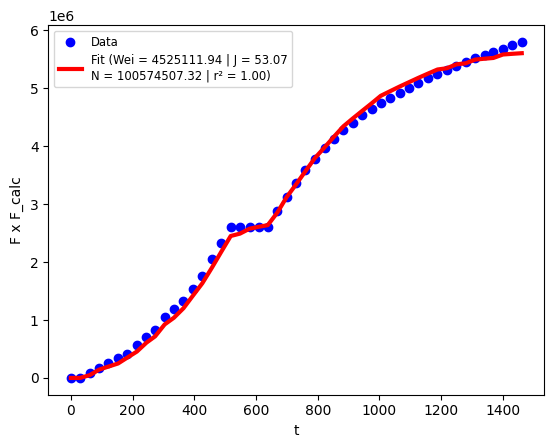

In [ ]:
## EBM generalizada
## We = F-N*(Eo+mEg+(1+m)Efw)
## F = N*(Eo+mEg+(1+m)Efw)+We

## Fetkovich
## ∆Wen = (Wei/pi).(pan-1-pn).[1-exp(-J.pi.∆t/Wei)]
## Wen = Wen-1+(Wei/pi).(pan-1-pn).[1-exp(-J.pi.∆t/Wei)]
## pan-1 = pi.[1-Wen-1/Wei]
## pn = [pn-1+pn]/2
## ∆t = t_j+1-t_j
## n = 1....n

##Aquífero Fetkovich

# Função objetivo
def objective(x, Eo, Eg, F, m):
    N = x[0]  # N é constante
    Wei = x[1]  # Wei é constante
    J = x[2]  # J é constante
    Wen = np.zeros(len(t))
    pa_med = np.zeros(len(t))
    pa_med[0] = p[0]
    for i in range(1,len(t)):
      Wen[i]=Wen[i-1]+(Wei/p[0])*(pa_med[i-1]-p_med[i])*(1-np.exp(-J*p[0]*dt[i]/Wei))
      pa_med[i]=p[0]*(1-(Wen[i-1]/Wei))
    F_calc = N * (Eo + m * Eg + (1 + m) * Efw) + Wen
    return np.sum((F - F_calc) ** 2)

# Chute inicial para N e We para cada t
x0 = np.array([10**8] + [1] + [1])

# Limites para N, Wei e J
bounds = [(10**6, None)] + [(10**2, None)] + [(0.1, None)]

# Otimização com restrições
result = minimize(objective, x0, args=(Eo, Eg, F, m), bounds=bounds)

N_est = result.x[0]
Wei_est = result.x[1]
J_est = result.x[2]

print(f"Estimativa de N: {N_est}")
print(f"Estimativa de Wei: {Wei_est}")
print(f"Estimativas de J: {J_est}")

Wen = np.zeros(len(t))
pa_med = np.zeros(len(t))
pa_med[0] = p[0]
for i in range(1,len(t)):
  Wen[i] = Wen[i-1]+(Wei_est/p[0])*(pa_med[i-1]-p_med[i])*(1-np.exp(-J_est*p[0]*dt[i]/Wei_est))
  pa_med[i] = p[0]*(1-(Wen[i-1]/Wei_est))

print(pa_med)

F_calc = N_est * (Eo + m * Eg + (1 + m) * Efw) + Wen
r2_2 = r2_score(F, F_calc)
print(r2_2)

plt.scatter(t, F, label="Data", color="blue")
plt.plot(t, F_calc, label=f"Fit (Wei = {Wei_est:0.2f} | J = {J_est:0.2f}" + "\n" + f"N = {N_est:0.2f} | r\N{SUPERSCRIPT TWO} = {r2_2:.2f})", color="red", linewidth=3)
plt.legend(fontsize='small')
plt.xlabel("t")
plt.ylabel("F x F_calc")
plt.show()

<ipython-input-12-2de18bfeebad>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  p_med[i]=(p_prev[i-1]+pn)/2


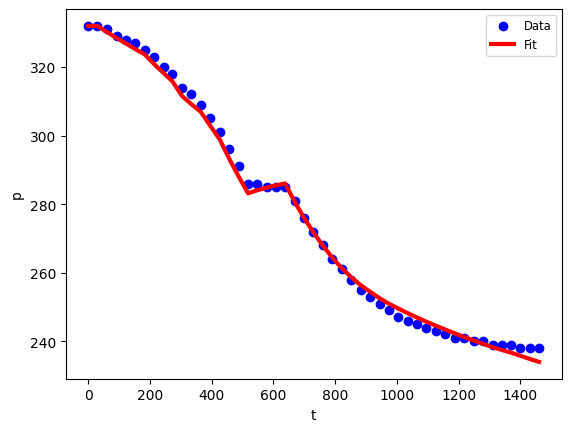

In [ ]:
## EBM generalizada
## We = F-N*(Eo+mEg+(1+m)Efw)
## F = N*(Eo+mEg+(1+m)Efw)+We
## We = F-N*(Eo+mEg+(1+m)Efw)
## Previsão

p_prev=np.zeros(len(t))
we_prev=np.zeros(len(t))
pa_med = np.zeros(len(t))
pa_med[0] = p[0]
p_prev = np.zeros(len(t))

def f_fet(pn, i):
    p_med[i]=(p_prev[i-1]+pn)/2
    # print(p_med[i])
    we_prev[i] = we_prev[i-1]+(Wei_est/p[0])*(pa_med[i-1]-p_med[i])*(1-np.exp(-J_est*p[0]*dt[i]/Wei_est))
    pa_med[i] = p[0]*(1-(we_prev[i-1]/Wei_est))
    # print(we_prev[i])
    return we_prev[i]

def f_ebm(pn, i):
    Bo=bob+co*bob*(pb-pn)
    Bg=1.40676*pn**(-1.04229)
    F=npp[i]*(Bo+(rp[i]-Rsi)*Bg)+(wp[i]-winj[i])*Bw
    Eo=Bo-bo[0]
    Eg=bo[0]*(Bg/bg[0]-1)
    Efw=bo[0]*((cf+cw*Swi)/(1-Swi))*(p[0]-pn)
    EBM=F-N_est*(Eo+m*Eg+(1+m)*Efw)
    # print(EBM)
    return EBM

for i in range(len(t)):
    if i == 0:
        p_prev[i]=p[0]
        we_prev[i]=0
        pa_med[0]=p[0]
    else:
        pn=p_prev[i-1]
        def f_obj(pn):
            Aquif=f_fet(pn, i)
            EBM=f_ebm(pn, i)
            return(EBM-Aquif)
        result=f_obj(pn)
        const = {'type':'eq', 'fun': f_obj}
        result=minimize(f_obj, pn, constraints=const)
        p_prev[i]=result.x[0]

plt.scatter(t, p, label="Data", color="blue")
plt.plot(t, p_prev, label="Fit", color="red", linewidth=3)
# plt.plot(t, df["Press_b"], label="Benchmark", color="black", linewidth=2, linestyle='--')
plt.legend(fontsize='small')
plt.xlabel("t")
plt.ylabel("p")
plt.show()